### .Imports

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import numpy as np
import codecs
import folium
from scipy.stats.stats import pearsonr

%pylab inline
pylab.rcParams['figure.figsize'] = (20,12)

Populating the interactive namespace from numpy and matplotlib


### .Constants

In [47]:
DATA_FOLDER = '../data_clean'
IS_DATE = re.compile("^[1-2]{1}[0-9]{3}$") #will be useful to detect values that correspond to dates

geo_center_ch = [46.8, 8.23] # Alggi-Alp

CANTON_TOPO_PATH = './ch-cantons.topojson.json'
CANTON_TOPO = json.load(open(CANTON_TOPO_PATH))

PATH = 'docs/_stories/'
PLOT_FOLDER = 'plots/'
DF_FOLDER = 'dataframes/'
MAP_FOLDER = 'maps/'

### .Useful functions

#### Function to quickly describe a dataframe

In [3]:
def describeDf(df,name="DESCRIPTION",level=2):
    """
    Describe the data. Different levels are possible.
    Level 0: Print the title of the dataset
    Level 1: Name the different columns
    Level 2: Explore the values of each column
    """
    date=[]
    
    # Explore each column of the dataset
    if(level==2):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        print("\n")
        for col in df.columns:
            # Print the attributes of each column
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                print("         ATTRIBUTE: "+col)
                print("   "+str(df[col].unique()))
                print("\n")
            else:
                date.append(col)
        # Print the years we have information on
        print("         VALUES: "+str(date))
        print("\n\n\n")
        return
    
    # Recover and print the columns of the datasets
    elif(level==1):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        val = []
        # Print the different columns
        for col in df.columns:
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                val.append(col)
        print(val)
        print("\n\n\n")
        return
    
    # Simply print the name of the dataset
    elif(level==0):
        print("   >  " + name+"\n")
    
    # Sanity check: the given level does exist
    else:
        raise NotImplementedError

#### Function to restrict the dataframe to a fix period in term of years

We need this function as our different datasets are often based on different yearly periods.

In [4]:
def get_period(df, start=None,end=None):
    """
    Function to keep the columns of interest of a dataset, between a starting and an ending date.
    """
    columns_to_keep = []
    dates = []
    
    # Go through the columns
    for elem in df.columns:
        # If it is not a date we keep it
        if not IS_DATE.match(elem):
            columns_to_keep.append(elem)
        # Else we store it to see later if we keep it
        else:
            dates.append(int(elem))
    
    # Define the starting and ending dates in the case they are not
    if start == None:
        start = np.min(dates)
    if end == None:
        end = np.max(dates)
    
    # Only keep the columns of interest
    for date in dates:
        if (date<=end) & (date>=start):
            columns_to_keep.append(str(date))
    
    return df[columns_to_keep]

#### Function to get the age corresponding to the intervals as input

Using this functions will allow us to treat people between 40 and 50 years old as one group for example. Again, this is needed because of the disparity among the datasets, with some of them considering each age category differently, while others  groupped the people in different intervals. This functions allow us to compare and work with those different datasets.

In [5]:
def map_int_to_age(k,age_max):
    """
    Transform an integer to what is define as an age, i.e. 20 to '20 ans' ('20 years old')
    """
    if(k != 1 and k<age_max):
        return '{} ans'.format(k)
    if(k == 1):
        return '{} an'.format(k)
    if(k==age_max):
        if (age_max == 100):
            return '{} ans ou plus'.format(age_max)
        else:
            return '{} ans et plus'.format(age_max)

In [6]:
def build_age(intervals,age_max):
    """
    INPUT:  intervals: Array corresponding to the delimitation of the wanted intervals.
            age_max: The maximal age to consider.
    """
    ages_total = []
    
    # Build the intervals
    for i in range(len(intervals)-1):
        ages = []
        
        # We keep the first limit of the interval as its first element: this will
        # allow us to identify the different intervals later
        ages.append(intervals[i])
        
        # Put the corresponding ages in the interval
        for k in range(int(intervals[i]),int(intervals[i+1])):
            # Use our function
            age = map_int_to_age(k,age_max)
            ages.append(age)
            if(k==100):
                break
                
        # Store the interval we just created
        ages_total.append(ages)
    
    return ages_total

#### Mapping for the cantons

One recurrent problem we encountered, as presented in introduction, is the fact that different datasets have information in different languages. In general, we can treat them case by case, but it becomes a major issue when it comes to the Swiss cantons. As we wanted to do an in depth analysis and comparison of them, we needed to be able to refer them in different datasets.

We thus decided to build a dictionnary of every different mentioning of the cantons we found, with a little function to get the corresponding key, allowing us to compare cantons in different datasets.

In [7]:
dict_cantons = dict()
dict_cantons['AA'] = ['Appenzell Rh.-Ext.','Appenzell Ausserrhoden']
dict_cantons['AG'] = ['Argovie','Aargau']
dict_cantons['AI'] = ['Appenzell Rh.-Int.','Appenzell Innerrhoden']
dict_cantons['BE'] = ['Berne', 'Bern', 'Bern / Berne']
dict_cantons['BL'] = ['Bâle-Campagne','Basel-Landschaft']
dict_cantons['BS'] = ['Bâle-Ville','Basel-Stadt']
dict_cantons['FR'] = ['Fribourg', 'Freiburg', 'Fribourg / Freiburg']
dict_cantons['GE'] = ['Genève', 'Genf']
dict_cantons['GL'] = ['Glaris', 'Glarus']
dict_cantons['GR'] = ['Grisons', 'Graubünden', 'Grigioni', 'Grischun', 'Graubünden / Grigioni / Grischun']
dict_cantons['JU'] = ['Jura']
dict_cantons['LU'] = ['Lucerne', 'Luzern']
dict_cantons['NE'] = ['Neuchâtel']
dict_cantons['NW'] = ['Nidwald', 'Nidwalden']
dict_cantons['OW'] = ['Obwald', 'Obwalden']
dict_cantons['SG'] = ['St. Gall', 'St. Gallen', 'Saint-Gall']
dict_cantons['SH'] = ['Schaffhouse', 'Schaffhausen']
dict_cantons['SO'] = ['Soleure', 'Solothurn']
dict_cantons['SZ'] = ['Schwytz', 'Schwyz']
dict_cantons['TE'] = ['Tessin', 'Ticino']
dict_cantons['TG'] = ['Thurgovie', 'Thurgau']
dict_cantons['UR'] = ['Uri']
dict_cantons['VS'] = ['Valais', 'Wallis', 'Valais / Wallis']
dict_cantons['VD'] = ['Vaud']
dict_cantons['ZG'] = ['Zoug', 'Zug']
dict_cantons['ZH'] = ['Zurich', 'Zürich']


def getKeysByValue(dictOfElements, valueToFind):
    '''
    Find the key of a canton.
    '''
    for item  in dictOfElements.items():
        if valueToFind==item[0]:
            return valueToFind
        if valueToFind in item[1]:
            return item[0]
            break
    raise NotImplementedError

We also implemented the following function to change all the cantons names to their key

In [8]:
def clean_cantons_names(x):
    clean = x.copy()
    for cant in clean['canton'].unique():
        # Check if what is recorded as a 'canton' really is a canton, i.e. is in our
        # dictionary (this doesn't keep the Swiss totals for example)
        try:
            getKeysByValue(dict_cantons, cant)
        # If not, we don't keep the rows with those 'cantons'
        except:
            clean = clean[clean.canton!=cant]

    # Replace the cantons name by their keys to compare them below
    clean['canton'] = [getKeysByValue(dict_cantons, cant) for cant in clean['canton']]
    
    return clean

And the list of the cantons keys to be able to put every dataframe in the same order

In [9]:
list_cantons_keys = []
for key in dict_cantons.keys():
    list_cantons_keys.append(key)

#### Function to plot a set of data

In [10]:
def plot_dataframe(x, y=None, title=None, xlabel=None, ylabel=None, labels=None,\
                   rotation=0, number_to_plot=None, bars=None,name_save=None):
    if number_to_plot == None:
        try:
            number_to_plot = y.shape[0]
        except:
            pass
    if bars == None:
        plt.figure(figsize=(12,7))
        for j in range(number_to_plot):
            plt.plot(x, y.iloc[j], label = labels[j])
    else:
        x.plot(kind=bars, figsize=(12,7))
    plt.title(title, fontsize=18)
    plt.legend(fontsize=10, loc=0, bbox_to_anchor=(1,1))
    plt.xticks(rotation=rotation, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    if (name_save!=None):
        plt.savefig(PATH+PLOT_FOLDER+name_save+'.png')
    plt.show()
    

#### Function to scatter plot correlations

In [11]:
def plot_correlation(x, y, title=None, xlabel=None, ylabel=None, labels=None,\
                   rotation=0, number_to_plot=None,name_save=None):
    if number_to_plot == None:
        try:
            number_to_plot = y.shape[0]
        except:
            pass
    plt.figure(figsize=(12,7))
    for j in range(number_to_plot):
        plt.scatter(x.iloc[j], y.iloc[j], label = labels[j])
    plt.title(title, fontsize=18)
    plt.legend(fontsize=10, loc="best", bbox_to_anchor=(1,1))
    plt.xticks(rotation=rotation, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    if (name_save!=None):
        plt.savefig(PATH+PLOT_FOLDER+name_save+'.png')
    plt.show()
    

#### Function to save results in order to put in the datastory

In [71]:
def save_it(data, name):
    if (type(data) == type(pd.DataFrame())):
        with codecs.open(PATH+DF_FOLDER+name+'.html','w',"utf-8") as f: 
            f.write(data.to_html())
            return 0
    if (type(data) == type(NewMap())):
        data.save(PATH+MAP_FOLDER+name+".html")
        return 0
    raise NotImplementedError
    

#### Homemade rewriting of the folium

> Since the `choropleth` method in folium is depreciated and doesn't display the `NaN values` right, we decide to add a new function to folium to make choropleth map.

In [28]:
import branca
from folium.folium import color_brewer, StepColormap

class NewMap(folium.Map):

    def color_map(self, data, columns, topo_data, objects,
                  legend=None, all_columns = None, layer_name ='', color_domain=[], fill_opacity=0.8, nan_opacity=0.3,
                  line_weight=1, line_opacity=1, key_on='id',show=True, multiMap=False):

        """
        data: dataframe
        columns: tuple of the column headers of the keys and the data to be used
        topo_data: topojson file
        objects: objects path of your topo json file
        layer_name: Name of the color layer. Put 'None' if you don't want to print any 
                    legend
        color_domain: list of the color scale in legend, it is automatically defined with
                        the minimum and maximum of your data if no list is provided.
        multiMap: bool that informs wether it is possible to change the map interactively or not,
                        if yes, we want that both maps plotted interactively use the same color scale
        """
        
        # Fix the color scale: from yellow to red in our case

        if all_columns == None:
            all_columns = [columns[1]]
                # only for interactive maps with two input choices
        lowLim=min( [min(data[all_columns[i]]) for i in range(0,len(all_columns))])   #we select overall min of both sets for the min of color scale
        upLim=max([max(data[all_columns[i]]) for i in range(0,len(all_columns))])    #same for max value of color scale
        colorscale = branca.colormap.linear.YlOrRd_09.scale(lowLim,upLim)
        
        # Redefine the styling function to blacken the NAN entries and color the other 
        # entries with the right color
        def style_function(feature):
            variation = (data[data[columns[0]] == feature[key_on]][columns[1]].values)
            if(variation != variation):
                return {
                'weight': line_weight,
                'opacity': line_opacity,
                'fillOpacity': nan_opacity,
                'color': 'black',
                'fillColor': '#black'
            }
            return {
                'weight': line_weight,
                'opacity': line_opacity,
                'fillOpacity': fill_opacity,
                'color': 'black',
                'fillColor': colorscale(variation)
            }

        # Define the colored layer using the predefine styling function
        geo_json = folium.TopoJson(topo_data,
                                   objects,
                                   style_function = style_function,
                                   name = layer_name,
                                   show=show
                                  )
        
        # Add the colored layer to our map
        self.add_child(geo_json)

        # If you want a color scale legend, add it
        if legend != None:
            
            # If the scale is not defined, define it automatically through the minimal
            # and maximal values
            if not color_domain:
                color_domain = np.arange(lowLim, upLim,(upLim-lowLim)/10)
                
            # Create the legend with the existing function
            brewed = color_brewer('YlOrRd', n=len(color_domain)-1)
            color_scale = StepColormap(
            brewed[0:len(color_domain)-1],    
            index=color_domain,
            vmin=color_domain[0],
            vmax=color_domain[-1],
            caption=legend,
            )
            
            # Add the legend to the map
            self.add_child(color_scale)

### .Datasets Loading

As mentioned, to perform our analysis, we took many datasets from the Swiss OpenData website. All these datasets are excels spreedsheet in differents forms, we hence needed to do a pre-treatment to transform them into clear `csv`
 files. They are stored in the folder `data_clean`.

The pre-treatment was huge since the datasets were sometimes split into multiple spreedsheets (on for each year) for example. Moreover, the excel files were organized to be visually good looking, with many merged cells and various hierachical levels in the data, thus requiring more work to clean and ready it for the future processings with pandas. 

#### Snapshot of our different datasets

In [14]:
dataframes = {}
print("  DATAFRAMES AVAILABLES:\n")

for file in os.listdir(DATA_FOLDER):
    # Load the filename
    filename = os.fsdecode(file)
    # Name the corresponding DataFrame "df_....."
    tablename = "df_"+os.path.splitext(os.path.splitext(filename)[0])[0]
    # Load the values in the DataFrame
    globals()[tablename] = pd.read_csv(DATA_FOLDER + '/' + filename)
    try:
        globals()[tablename] = globals()[tablename].drop(columns=['Unnamed: 0'])
    except:
        pass
    # Print the title of the datasets
    describeDf(globals()[tablename], name=tablename,level=0)
    dataframes[tablename] = globals()[tablename] 

  DATAFRAMES AVAILABLES:

   >  df_Accident_cantons

   >  df_Accident_circonstances

   >  df_Accident_objets

   >  df_Accident_type_route

   >  df_Accident_victimes

   >  df_Besoin_sante

   >  df_Depense_menages_canton

   >  df_Frais_routes_cantonales

   >  df_Frais_routes_communales

   >  df_Frais_routes_nationales

   >  df_hacked_accident

   >  df_Longueur_routes

   >  df_Population_2010

   >  df_Population_age_1992

   >  df_Population_canton_1992

   >  df_Proportion_permis

   >  df_Qualite_vie_agglo

   >  df_Recettes_routes

   >  df_Voitures



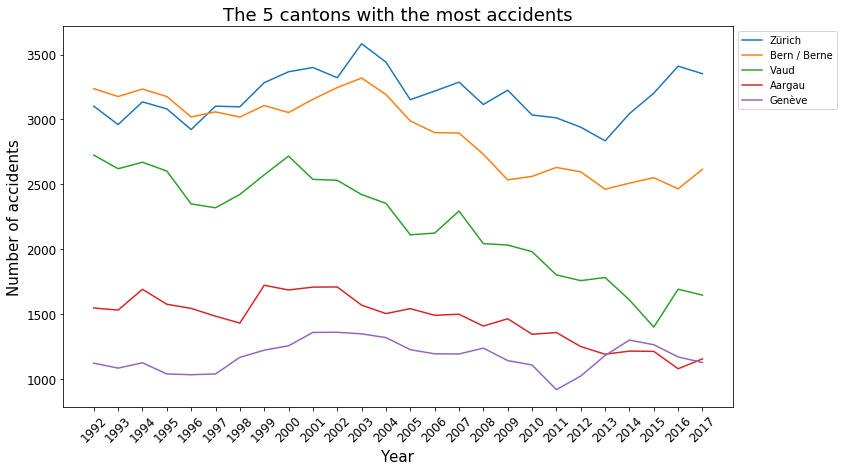

In [112]:
# Delete the row that doesn't contain any information
df_Accident_cantons = df_Accident_cantons.dropna()

# Compute the total accidents per canton, sort them and keep the wanted columns
df_cantons = df_Accident_cantons.groupby(['canton']).sum().\
        sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]

# As an example, plot the 5 cantons with the most accidents
plot_dataframe(x=df_cantons.columns.values, y=df_cantons.head(5),\
               title="The 5 cantons with the most accidents", xlabel='Year',\
               ylabel='Number of accidents', labels=df_cantons.head(5).index.values,\
               rotation=45, number_to_plot=None)
df_cantons = clean_cantons_names(df_cantons.reset_index())

In [86]:
def create_map(dataframe,columns,legend,column_canton='canton'):
    layerControl = True
    if (type(columns)!=type([])):
        columns=[columns]
        layerControl = False
    MAP = NewMap(geo_center_ch,  zoom_start=8, tiles='cartodbpositron')
    show = True
    for elem in reversed(columns):
        MAP.color_map(data=dataframe,
                      columns=[column_canton, elem],
                      all_columns=columns,
                      topo_data=CANTON_TOPO,
                      objects='objects.cantons',
                      layer_name = str(elem),
                      legend=legend,
                    show=show)
        show = False
        legend = None
    if layerControl:
        folium.LayerControl().add_to(MAP)
    return MAP

In [76]:
MAP = create_map(df_cantons,[d for d in df_cantons.columns if IS_DATE.match(d)][15:],'Cars Accident')


In [ ]:
branca.colormap.linear.YlOrRd.scale(0,100)

In [27]:
color_domain = np.arange(0, 100,(100-0)/10)
color_brewer('YlOrRd', n=len(color_domain)-1)

['#ffffcc',
 '#ffeda0',
 '#fed976',
 '#feb24c',
 '#fd8d3c',
 '#fc4e2a',
 '#e31a1c',
 '#bd0026',
 '#800026']

In [119]:
df_cantons_2 = df_cantons.copy()
for i in reversed(range(1993,2018)):
    df_cantons_2[str(i)] = (df_cantons_2[str(i)]-df_cantons_2[str(i-1)])*100/df_cantons_2[str(i-1)]

In [125]:
MAP = create_map(df_cantons_2,[d for d in df_cantons_2.columns if IS_DATE.match(d)][1:],'Variation compare to the previous year')

In [123]:
MAP

In [140]:
dates = [d for d in df_Accident_cantons.columns if IS_DATE.match(d)]
df_proportion_death_canton = 100*df_Accident_cantons[df_Accident_cantons.gravite_index==317].groupby('canton').sum()[dates]/df_Accident_cantons.groupby('canton').sum()[dates]
df_proportion_death_canton = clean_cantons_names(df_proportion_death_canton.reset_index())

In [141]:
df_proportion_death_canton

canton      1992      1993       1994       1995      1996      1997  \
0      AG  3.619910  3.200523   2.956830   3.045685  2.331606  2.964960   
1      AA  4.545455  5.072464   1.481481   3.149606  1.769912  3.669725   
2      AI  6.250000  3.333333  10.344828  13.157895  7.407407  8.333333   
3      BL  3.310105  2.355072   2.967359   2.900552  3.144654  1.971831   
4      BS  1.502732  1.143583   1.041667   1.048951  0.636943  1.097561   
5      BE  2.873031  2.487406   2.442795   2.455919  2.649884  1.831262   
6      FR  5.833333  4.886562   3.605016   4.858934  4.332130  3.846154   
7      GE  2.495544  2.675277   2.133333   1.636189  1.839303  1.636189   
8      GL  3.636364  2.040816   4.545455   4.938272  2.272727  6.896552   
9      GR  4.273504  3.703704   4.198473   2.699229  3.074866  2.872777   
10     JU  8.035714  3.643725   3.045685   4.587156  3.301887  6.770833   
11     LU  2.533937  2.551985   2.365184   2.873031  2.707930  2.014011   
12     NE  5.096661  3.088803   4.259259   2.886598  2.127660  2.863436   
13     NW  3.883495  1.219512   0.000000   2.777778  1.769912  0.000000   
14     OW  3.539823  5.454545   6.000000   3.191489  6.250000  1.098901   
15     SH  4.166667  5.960265   4.060914   0.555556  1.156069  3.030303   
16     SZ  5.288462  5.347594   5.060241   2.569593  3.526448  3.439803   
17     SO  2.737940  2.574003   1.845018   2.377972  2.500000  2.395965   
18     SG  3.587786  2.269289   2.372128   3.562945  3.053435  3.874691   
19     TG  3.079179  3.794038   3.945372   4.575163  3.508772  3.993610   
20     TE  2.032750  2.089379   2.610670   2.049180  1.706277  1.723077   
21     UR  3.731343  4.929577   2.453988   5.978261  4.819277  5.454545   
22     VS  5.510907  4.048140   3.771290   5.443038  4.674221  3.819918   
23     VD  2.715596  2.557252   2.247191   2.651806  2.426564  2.371712   
24     ZG  1.628664  1.935484   0.803213   1.846154  2.826855  3.934426   
25     ZH  2.901354  3.175676   2.679426   2.336904  2.464066  2.095422   

        1998      1999      2000    ...         2008      2009      2010  \
0   1.677149  2.032520  2.253855    ...     1.349432  1.297814  0.892193   
1   2.400000  2.380952  0.884956    ...     2.380952  0.847458  1.626016   
2   3.333333  3.030303  0.000000    ...     9.302326  3.030303  8.571429   
3   2.529960  2.888583  1.837270    ...     1.250000  0.951087  1.472995   
4   1.241379  1.222826  0.454545    ...     1.010101  0.847458  1.049869   
5   2.253148  2.188606  2.129053    ...     1.537335  1.973165  1.405701   
6   2.684564  3.880597  4.268293    ...     2.287582  2.113821  1.743265   
7   1.542416  1.882160  1.433121    ...     0.888530  1.838879  1.263538   
8   2.380952  1.980198  1.980198    ...     2.884615  4.166667  0.000000   
9   3.311258  3.595206  2.446043    ...     2.622951  2.296820  4.795737   
10  4.694836  3.083700  5.069124    ...     3.750000  0.628931  3.870968   
11  2.490775  2.145923  1.853412    ...     1.233480  1.904762  1.552511   
12  4.612159  3.966597  2.912621    ...     1.333333  1.662050  1.628664   
13  0.000000  2.362205  0.000000    ...     0.000000  3.409091  0.000000   
14  5.042017  2.469136  5.494505    ...     1.123596  1.818182  6.818182   
15  2.976190  0.000000  3.482587    ...     2.424242  0.000000  1.503759   
16  2.211302  1.895735  1.799486    ...     2.732240  2.873563  3.351955   
17  2.251656  1.990632  2.305159    ...     0.947867  1.067616  0.709220   
18  3.296703  2.587413  2.353780    ...     1.720094  1.502630  1.156069   
19  3.652968  3.062787  3.427720    ...     1.319648  1.255887  1.371951   
20  1.869761  2.786378  1.978417    ...     1.592357  1.646447  1.927913   
21  3.750000  4.487179  0.632911    ...     4.347826  2.013423  1.834862   
22  5.073431  4.335664  3.598015    ...     2.368866  2.495840  3.050847   
23  2.436003  2.215313  2.355539    ...     1.860010  2.066929  1.716305   
24  2.812500  1.307190  2.572347    ...     2.352941  1.729107  1.197605   
2

In [129]:
df_Accident_cantons

canton_index           canton  gravite_index  \
0             1.0           Zürich          315.0   
1             1.0           Zürich          315.0   
2             1.0           Zürich          315.0   
3             1.0           Zürich          316.0   
4             1.0           Zürich          316.0   
5             1.0           Zürich          316.0   
6             1.0           Zürich          317.0   
7             1.0           Zürich          317.0   
8             1.0           Zürich          317.0   
9             2.0     Bern / Berne          315.0   
10            2.0     Bern / Berne          315.0   
11            2.0     Bern / Berne          315.0   
12            2.0     Bern / Berne          316.0   
13            2.0     Bern / Berne          316.0   
14            2.0     Bern / Berne          316.0   
15            2.0     Bern / Berne          317.0   
16            2.0     Bern / Berne          317.0   
17            2.0     Bern / Berne          317.0   
18            3.0           Luzern          315.0   
19            3.0           Luzern          315.0   
20            3.0           Luzern          315.0   
21            3.0           Luzern          316.0   
22            3.0           Luzern          316.0   
23            3.0           Luzern          316.0   
24            3.0           Luzern          317.0   
25            3.0           Luzern          317.0   
26            3.0           Luzern          317.0   
27            4.0              Uri          315.0   
28            4.0              Uri          315.0   
29            4.0              Uri          315.0   
..            ...              ...            ...   
204          23.0  Valais / Wallis          317.0   
205          23.0  Valais / Wallis          317.0   
206          23.0  Valais / Wallis          317.0   
207          24.0        Neuchâtel          315.0   
208          24.0        Neuchâtel          315.0   
209          24.0        Neuchâtel          315.0   
210          24.0        Neuchâtel          316.0   
211          24.0        Neuchâtel          316.0   
212          24.0        Neuchâtel          316.0   
213          24.0        Neuchâtel          317.0   
214          24.0        Neuchâtel          317.0   
215          24.0        Neuchâtel          317.0   
216          25.0           Genève          315.0   
217          25.0           Genève          315.0   
218          25.0           Genève          315.0   
219          25.0           Genève          316.0   
220          25.0           Genève          316.0   
221          25.0           Genève          316.0   
222          25.0           Genève          317.0   
223          25.0           Genève          317.0   
224          25.0           Genève          317.0   
225          26.0             Jura          315.0   
226          26.0             Jura          315.0   
227          26.0             Jura          315.0   
228          26.0             Jura          316.0   
229          26.0             Jura          316.0   
230          26.0             Jura          316.0   
231          26.0             Jura          317.0   
232          26.0             Jura          317.0   
233          26.0             Jura          317.0   

                           gravite  ruralite_index       ruralite    1992  \
0    Accidents avec blessés légers            10.0    En localité  1323.0   
1    Accidents avec blessés légers            11.0  Hors localité   388.0   
2    Accidents avec blessés légers            12.0  Sur autoroute   114.0   
3    Accidents avec blessés graves            10.0    En localité   933.0   
4    Accidents avec blessés graves            11.0  Hors localité   200.0   
5    Accidents avec blessés graves            12.0  Sur autoroute    54.0   
6                Accidents mortels            10.0    En localité    46.0   
7                Accidents mortels            11.0  Hors localité    35.0   
8                Accident